In [2]:
# install  required packages
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from wordcloud import WordCloud
import networkx as nx
import re
import spacy
from spacy.matcher import Matcher


import warnings
warnings.filterwarnings("ignore")

In [3]:
random_seed = 30224
np.random.seed(random_seed)

In [4]:
# load the dataset
dat = pd.read_csv('./CNN_Articels_clean_2/CNN_Articels_clean.csv')
dat.head(3)

Index                                             Author  \
0      0                                 Jacopo Prisco, CNN   
1      1                              Stephanie Bailey, CNN   
2      2  Words by Stephanie Bailey, video by Zahra Jamshed   

        Date published Category Section  \
0  2021-07-15 02:46:59     news   world   
1  2021-05-12 07:52:09     news   world   
2  2021-06-16 02:51:30     news    asia   

                                                 Url  \
0  https://www.cnn.com/2021/07/14/world/tusimple-...   
1  https://www.cnn.com/2021/05/12/world/ironhand-...   
2  https://www.cnn.com/2021/06/15/asia/swarm-robo...   

                                            Headline  \
0  There's a shortage of truckers, but TuSimple t...   
1  Bioservo's robotic 'Ironhand' could protect fa...   
2  This swarm of robots gets smarter the more it ...   

                                         Description  \
0  The e-commerce boom has exacerbated a global t...   
1  Working in a factory can mean doing the same t...   
2  In a Hong Kong warehouse, a swarm of autonomou...   

                                            Keywords  \
0  world, There's a shortage of truckers, but TuS...   
1  world, Bioservo's robotic 'Ironhand' could pro...   
2  asia, This swarm of robots gets smarter the mo...   

                                     Second headline  \
0  There's a shortage of truckers, but TuSimple t...   
1  A robotic 'Ironhand' could protect factory wor...   
2  This swarm of robots gets smarter the more it ...   

                                        Article text  
0   (CNN)Right now, there's a shortage of truck d...  
1   (CNN)Working in a factory or warehouse can me...  
2   (CNN)In a Hong Kong warehouse, a swarm of aut...

In [5]:
# extract the year from date
dat['year'] = pd.DatetimeIndex(dat['Date published']).year

In [4]:
dat.isna().any()

Index              False
Author             False
Date published     False
Category           False
Section            False
Url                False
Headline           False
Description        False
Keywords           False
Second headline    False
Article text        True
dtype: bool

In [5]:
dat['Category'].unique()

array(['news', 'business', 'health', 'entertainment', 'sport', 'politics',
       'travel', 'vr', 'style'], dtype=object)

Exploratory Analysis

In [4]:
fig = px.histogram(dat, x="Category")
fig.update_layout(height=400, width=600)
fig.show()

In [34]:
fig = px.histogram(dat, x="year")
fig.update_layout(height=400, width=600, bargap=0.2)
fig.show()

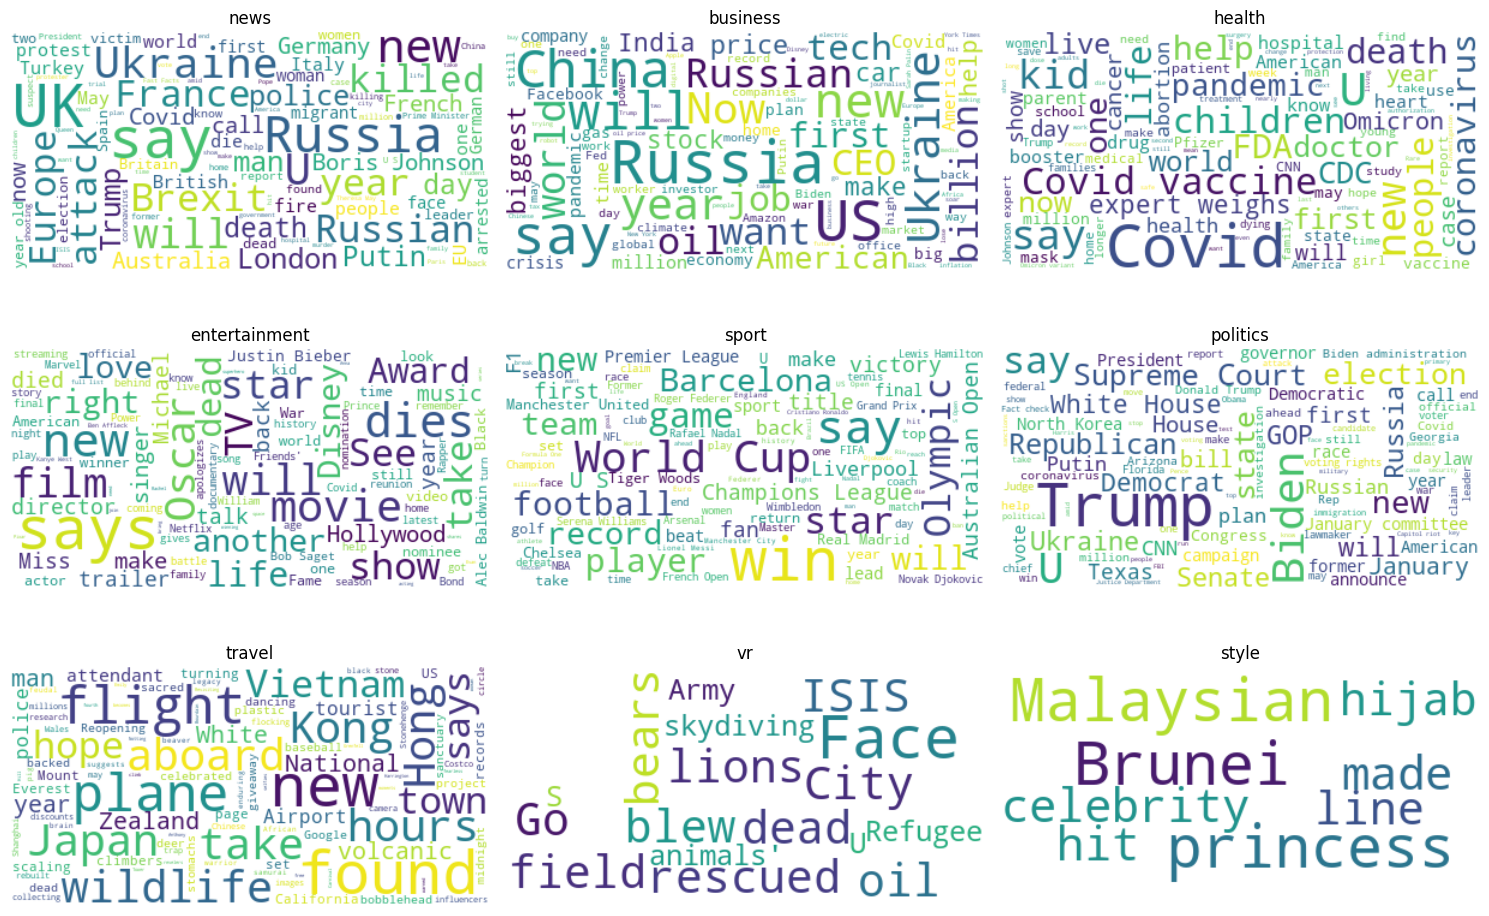

In [6]:
categories = dat['Category'].unique()

fig = plt.figure(figsize=(15,10))
# generate wordclouds for each category
for i in range(len(categories)):
    category = categories[i]
    text = " ".join(dat[dat['Category'] == category]['Second headline'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    plt.title(category)

plt.tight_layout()
    

Preprocessing

In [7]:
def preprocessing(text):

    # remove " 's "
    text = text.replace("'s", "")

    # remove punctuations
    text = text.translate(str.maketrans('','', string.punctuation))
    
    # remove short words
    text = ' '.join([w for w in text.split() if len(w)>1])

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove more words
    words = ['the']
    text = ' '.join([w for w in text.split() if w not in words])

    # replace plural forms with singular forms
    singulars = ['Democrat','Republican', 'Americans', 'Russians']
    plurals = ['Democrats','Republicans', 'America', 'Russia']
    for s in range(len(singulars)):
        text = text.replace(plurals[s], singulars[s])

    # replace more words
    long = ['Joe Biden','Donald Trump', 'George Bush', 'Barack Obama', 'Boris Johnson',
            'American', 'Russian']
    short = ['Biden','Trump', 'Bush', 'Obama','Johnson', 
            'America', 'America', 'Russia']
    for s in range(len(long)):
        text = text.replace(long[s], short[s])
    
    # remove whitespace
    text = ' '.join(text.split())

    return text

sample = '"They what they ordered, right?:  1000  Democrats search midterm message party gatherings# Biden\'s got a message. Joe Biden is a democrat"'
preprocessing(sample)

'They what they ordered right Democrat search midterm message party gatherings Biden got message Biden is democrat'

In [8]:
# select year and second headline columns from dat dataframe
tidy_dat = dat[['Category','Second headline', 'year']]
tidy_dat['tidy_Second headline'] = tidy_dat['Second headline'].apply(preprocessing)
tidy_dat.head(3)

Category                                    Second headline  year  \
0     news  There's a shortage of truckers, but TuSimple t...  2021   
1     news  A robotic 'Ironhand' could protect factory wor...  2021   
2     news  This swarm of robots gets smarter the more it ...  2021   

                                tidy_Second headline  
0  There shortage of truckers but TuSimple thinks...  
1  robotic Ironhand could protect factory workers...  
2    This swarm of robots gets smarter more it works

#### Topic Modeling

In [9]:
def term_topics(data, year):
    
    headlines = data[data['year']==year]['tidy_Second headline']

    # Removing say and says as stopwords:
    remove_list = ["say", "says"]
    for word in remove_list:
        headlines = headlines.str.replace(word, " ")

    # Tokenization
    tokenized_headline = headlines.apply(lambda x: x.split())

    # Stemming
    stemmer = PorterStemmer()

    tokenized_headline = tokenized_headline.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

    bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
    # bag-of-words feature matrix
    bow = bow_vectorizer.fit_transform(headlines)

    svd= TruncatedSVD(n_components=5) # 5 topics
    lsa=svd.fit_transform(bow)

    Sigma = svd.singular_values_
    terms = bow_vectorizer.get_feature_names()

    data_dict = {'Year': [], 'Topic': [], 'Top_Terms': []}

    for index, component in enumerate(svd.components_):
        zipped = zip(terms, component)
        top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:10]
        top_terms_list = list(dict(top_terms_key).keys())

        data_dict['Year'].append(year)
        data_dict['Topic'].append(index)
        data_dict['Top_Terms'].append(top_terms_list)

    return pd.DataFrame(data_dict)

result_df = pd.DataFrame()

for year in range(2011, 2023):
    result_df = pd.concat([result_df, term_topics(tidy_dat[tidy_dat['Category'].isin(['news', 'politics'])], year)])

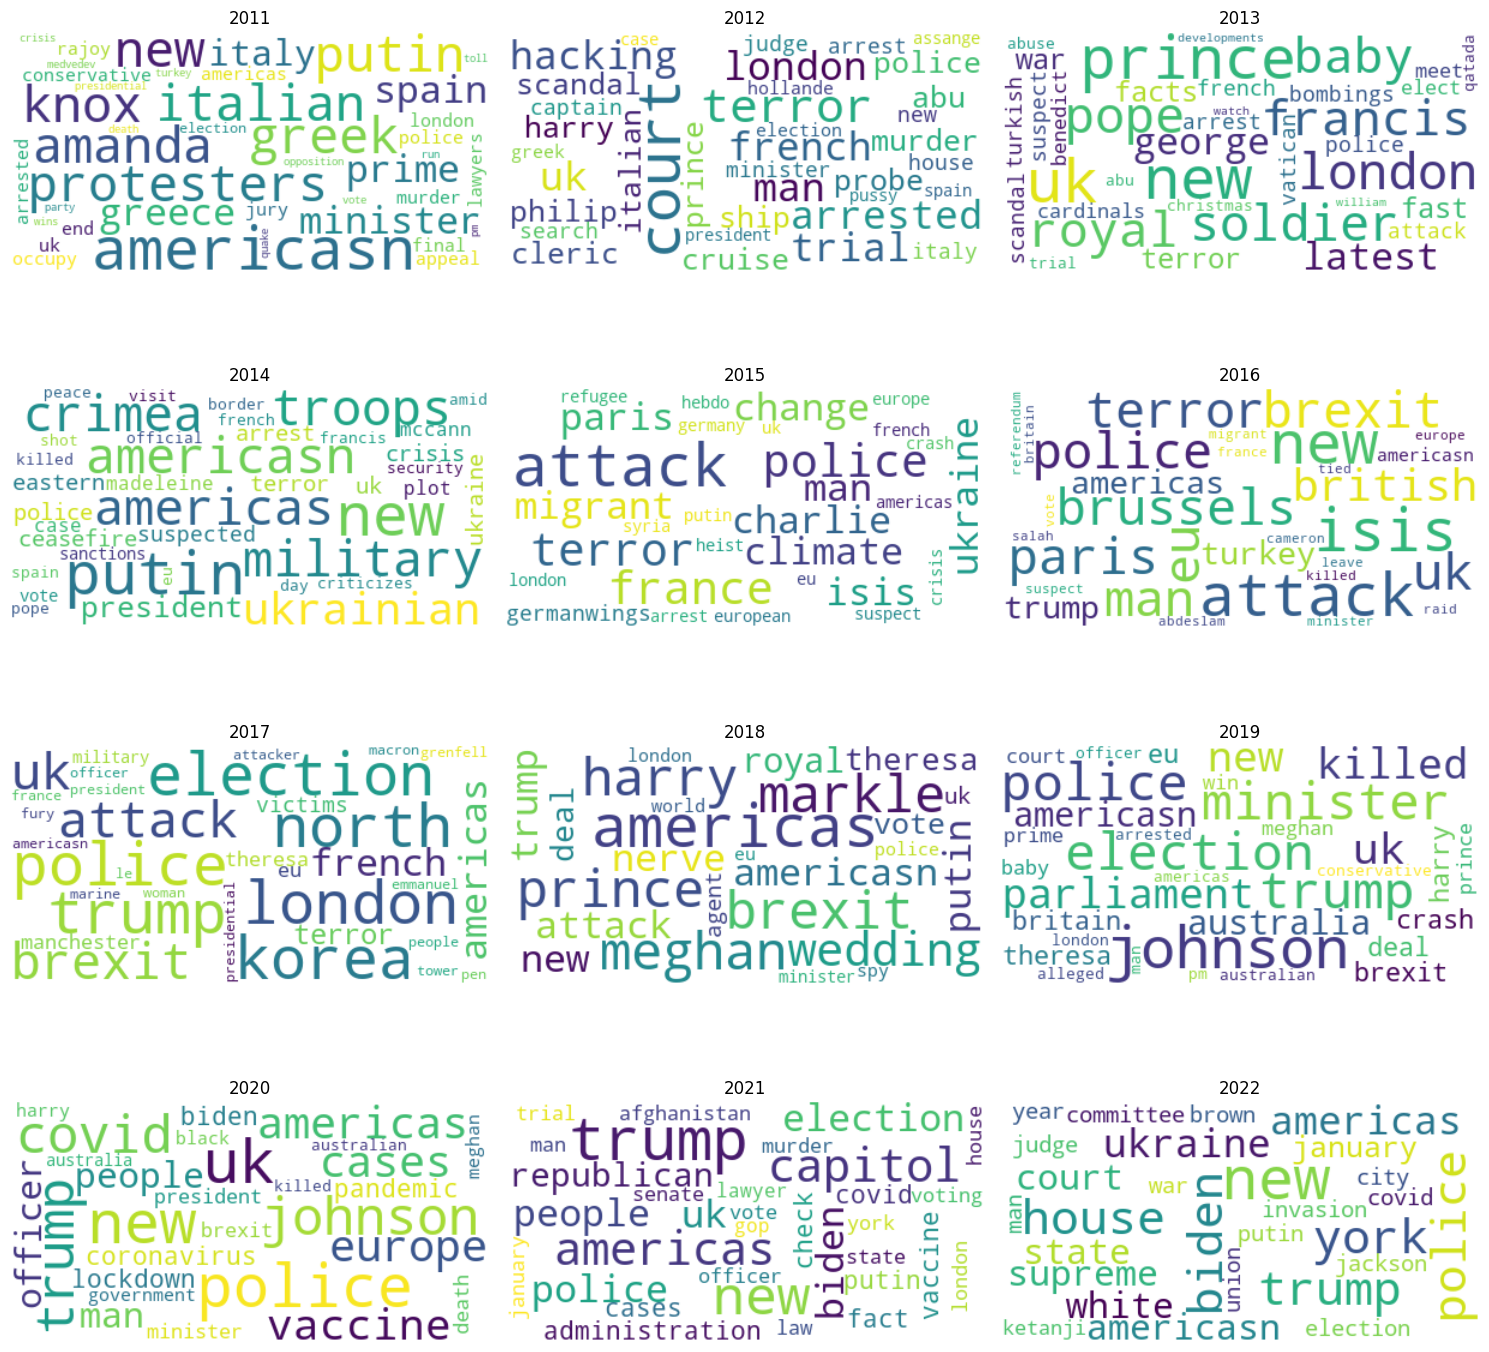

In [77]:
years = result_df['Year'].unique()

# generate wordclouds for each year
fig = plt.figure(figsize=(15,15))
for i in range(len(years)):
    year = years[i]
    top_terms = result_df[result_df['Year'] == year]['Top_Terms'].explode().tolist()
    wordcloud = WordCloud(max_font_size=50, background_color='white').generate(' '.join(top_terms))
    ax = fig.add_subplot(4,3,i+1)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    plt.title(year)

plt.tight_layout()

In [97]:
# Perform Latent Dirichlet Allocation
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from nltk.tokenize import word_tokenize

dat_topic = tidy_dat[tidy_dat['Category'].isin(['news', 'politics'])]['tidy_Second headline']

# More preprocessing

# remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

dat_topic = dat_topic.apply(lambda x: remove_stopwords(x))

# Removing more stopwords:
remove_list = ["say", "says", "the"]
for word in remove_list:
    dat_topic = dat_topic.str.replace(word, " ")

# remove short words
dat_topic = dat_topic.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

# Tokenization
dat_topic = dat_topic.apply(lambda x: x.split())

# Stemming
stemmer = PorterStemmer()

dat_topic = dat_topic.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

# Create a dictionary from the preprocessed data
dictionary = Dictionary(dat_topic)

# Filter out words that appear in fewer than 5 documents or more than 50% of the documents
# dictionary.filter_extremes(no_below=5, no_above=0.5)

bow_corpus = [dictionary.doc2bow(text) for text in dat_topic]

# Train the LDA model
num_topics = 5
ldamodel = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='auto')

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

print('With Latent Dirichlet Allocation method')
# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print([word for word, _ in topic])
                                               

With Latent Dirichlet Allocation method
Topic: 0
['polic', 'attack', 'kill', 'minist', 'arrest', 'man', 'franc', 'suspect', 'leader', 'dead']
Topic: 1
['uk', 'america', 'ukrain', 'americasn', 'us', 'brexit', 'johnson', 'london', 'protest', 'may']
Topic: 2
['the', 'new', 'covid', 'year', 'europ', 'australia', 'british', 'coronaviru', 'trump', 'first']
Topic: 3
['princ', 'court', 'queen', 'parliament', 'spanish', 'greec', 'assang', 'philip', 'controversi', 'resid']
Topic: 4
['putin', 'death', 'eu', 'what', 'lockdown', 'plan', 'biden', 'lawmak', 'babi', 'car']


In [90]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(dat_topic.apply(lambda x: ' '.join(x)))

svd= TruncatedSVD(n_components=5) # 5 topics
lsa=svd.fit_transform(bow)

Sigma = svd.singular_values_
terms = bow_vectorizer.get_feature_names()

print('With Latent Semantic Analysis method')
for index, component in enumerate(svd.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

With Latent Semantic Analysis method
Topic 0:  ['uk', 'polic', 'attack', 'new', 'america', 'kill', 'americasn', 'trump', 'arrest', 'suspect']
Topic 1:  ['uk', 'brexit', 'johnson', 'parliament', 'eu', 'minist', 'govern', 'vote', 'theresa', 'prime']
Topic 2:  ['polic', 'attack', 'arrest', 'suspect', 'kill', 'london', 'offic', 'man', 'terror', 'shoot']
Topic 3:  ['trump', 'new', 'year', 'elect', 'vote', 'york', 'court', 'day', 'state', 'princ']
Topic 4:  ['new', 'year', 'princ', 'americasn', 'minist', 'court', 'harri', 'covid', 'york', 'prime']


#### Perform Network Cluster Analysis on each category

In [19]:
dat_politics = tidy_dat[tidy_dat['Category']=='politics']
dat_politics = dat_politics.reset_index(drop=True)
dat_politics.head(3)

Category                                    Second headline  year  \
0  politics  Biden administration formally determines Myanm...  2022   
1  politics  Fact check: A look at Biden's first year in fa...  2022   
2  politics  Fact check: Five enduring lies about the Capit...  2022   

                                tidy_Second headline  
0  Biden administration formally determines Myanm...  
1  Fact check look at Biden first year in false c...  
2  Fact check Five enduring lies about Capitol in...

In [20]:
nlp = spacy.load("en_core_web_sm")

def extract_names(text):
    doc = nlp(text)
    categories = ["PERSON", "ORG", "GPE", "PRODUCT", "FAC", "NORP"]

    names = []
    for ent in doc.ents:
        if ent.label_ in categories:
            names.append(ent.text.lower())
    return names

sample_text = ("Anatomy lie How the myth that Antifa stormed the Capitol became widespread belief among Republicans")
extract_names(sample_text)

['antifa', 'capitol', 'republicans']

Extract named entities in each headline

In [37]:
def headline_to_names(headlines):
    named_entities = []
    for headline in headlines:
        names = extract_names(headline)
        named_entities.append(' '.join(''.join(sublist) for sublist in names))

    named_entities = pd.DataFrame(named_entities)[0]
    return named_entities

In [46]:
def unique_entities_frequencies(headlines, min_df):

    named_entities = headline_to_names(headlines)

    bow_vectorizer_ner = CountVectorizer(max_df=0.9, 
                                         min_df=min_df,
                                         max_features=500, 
                                         ngram_range=(1,3))
    # bag-of-words feature matrix for named entities
    bow_ner = bow_vectorizer_ner.fit_transform(named_entities)

    terms = bow_vectorizer_ner.get_feature_names_out()
    frequency = np.asarray(bow_ner.sum(axis=0)).ravel()
    unique_entities = pd.DataFrame({'term':terms, 'frequency':frequency})
    
    return unique_entities

In [40]:
# if each headline contains unique_entities, store these rows in a new dataframe
def extract_unique_entities(headlines, min_df):

    unique_entities = unique_entities_frequencies(headlines, min_df)

    entities = []
    for headline in headlines:
        names = extract_names(headline)
        top_names = []
        for name in names:
            if name in unique_entities['term'].unique():
                top_names.append(name)
        entities.append(top_names)
    return entities


Create a network of named entities

In [47]:
# Create a graph
G = nx.Graph()

headlines = dat_politics['tidy_Second headline']
min_df = 50
entities = extract_unique_entities(headlines, min_df)
# Add nodes and edges based on word co-occurrences
for entity in entities:
    for i in range(len(entity)):
        for j in range(i + 1, len(entity)):
            # Increase the edge weight for each co-occurrence
            if G.has_edge(entity[i], entity[j]):
                G[entity[i]][entity[j]]['weight'] += 1
            else:
                G.add_edge(entity[i], entity[j], weight=1)

In [26]:
# Get the node sizes based on frequency of occurrence of the named entities
def get_node_size(G, headlines, min_df):
    nodes = np.array(G.nodes())
    node_size = []

    unique_entities = unique_entities_frequencies(headlines, min_df)
    df = unique_entities[unique_entities['term'].isin(nodes)]

    for node in nodes:
        if node in df['term'].unique():
            node_size.append(10*df[df['term']==node]['frequency'].values[0])
        else:
            node_size.append(10)
    return node_size

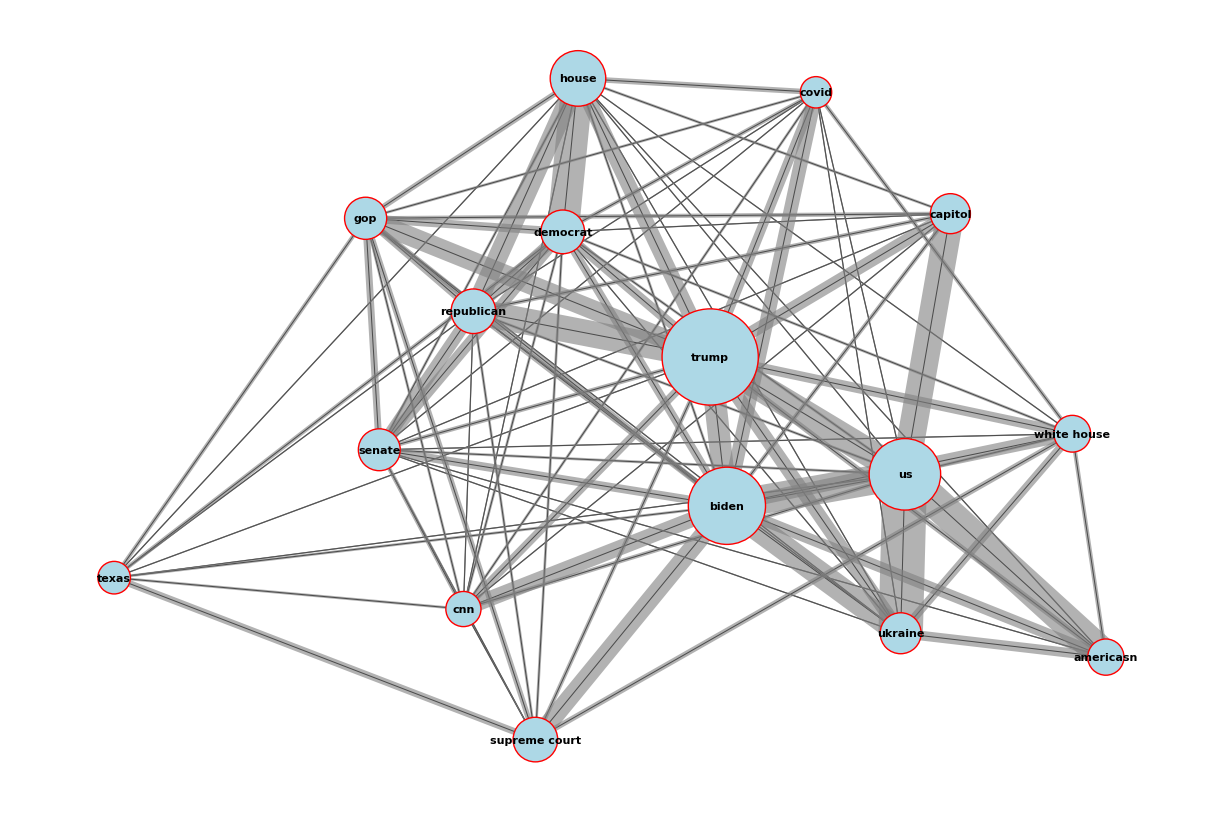

In [49]:
node_sizes = get_node_size(G, headlines, min_df)
# Draw the graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, scale = 5)  
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw(G, pos, with_labels=True, font_size=8, font_color='black', node_size=node_sizes, font_weight='bold', width = 0.75, edgecolors='red', node_color='lightblue')

# Add edge labels with weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, width = list(labels.values()), 
                        alpha = 0.6, edge_color = 'grey')

plt.show()

News Category

In [50]:
dat_news = dat[dat['Category']=='news']
dat_news = dat_news.reset_index(drop=True)
dat_news = dat_news[['year','Second headline']]

dat_news['tidy_Second headline'] = dat_news['Second headline'].apply(lambda x: preprocessing(x))
dat_news.head(3)

year                                    Second headline  \
0  2021  There's a shortage of truckers, but TuSimple t...   
1  2021  A robotic 'Ironhand' could protect factory wor...   
2  2021  This swarm of robots gets smarter the more it ...   

                                tidy_Second headline  
0  There shortage of truckers but TuSimple thinks...  
1  robotic Ironhand could protect factory workers...  
2    This swarm of robots gets smarter more it works

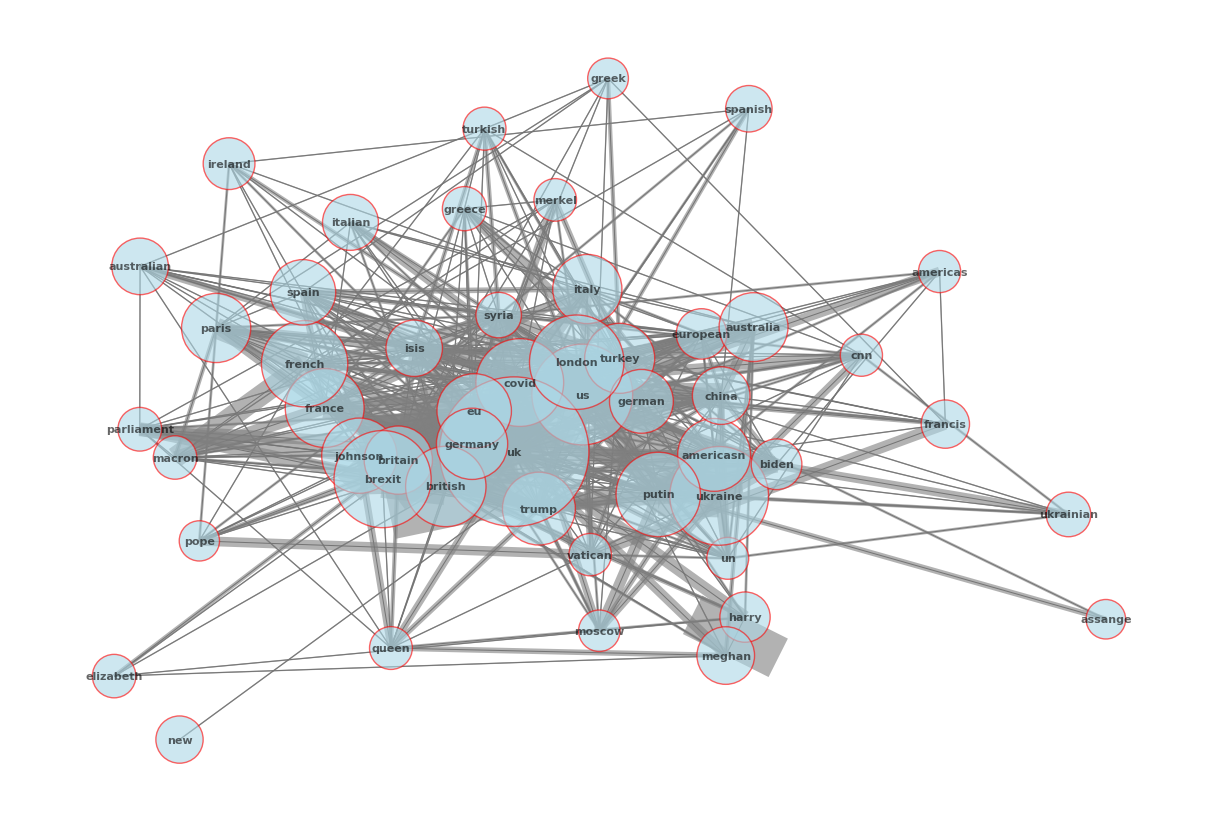

In [53]:
# Repeat the same process for news articles
headlines2 = dat_news['tidy_Second headline']
min_df = 80
entities2 = extract_unique_entities(headlines2, min_df)

# Create a graph
G2 = nx.Graph()
# Add nodes and edges based on word co-occurrences
for entity in entities2:
    for i in range(len(entity)):
        for j in range(i + 1, len(entity)):
            # Increase the edge weight for each co-occurrence
            if G2.has_edge(entity[i], entity[j]):
                G2[entity[i]][entity[j]]['weight'] += 1
            else:
                G2.add_edge(entity[i], entity[j], weight=1)

node_sizes = get_node_size(G2, headlines2, min_df)
# Draw the graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G2,  k = 1, iterations = 30)  
G2.remove_edges_from(nx.selfloop_edges(G2))
nx.draw(G2, pos, with_labels=True, font_size=8, font_color='black', 
        node_size=node_sizes, font_weight='bold', width = 0.75, 
        edgecolors='red', node_color='lightblue', alpha = 0.6)

# Add edge labels with weights
labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edges(G2, pos, width = list(labels.values()), 
                    alpha = 0.6, edge_color = 'grey')

plt.show()


In [ ]:
# create a dataframe with nodes and node sizes
df_nodes = pd.DataFrame({'node':list(G2.nodes()), 'node_size':node_sizes})
df_nodes = df_nodes.sort_values(by='node_size', ascending=False)
df_nodes.head(30)

Sport Category

In [54]:
dat_sport = dat[dat['Category']=='sport']
dat_sport = dat_sport.reset_index(drop=True)
dat_sport = dat_sport[['year','Second headline']]

dat_sport['tidy_Second headline'] = dat_sport['Second headline'].apply(lambda x: preprocessing(x))
dat_sport.head(3)

year                                    Second headline  \
0  2022  Cleveland Browns defend Deshaun Watson signing...   
1  2022  Bahrain Grand Prix: Ferrari dominates as Charl...   
2  2022  Lucrative Saudi-backed golf league is 'new opp...   

                                tidy_Second headline  
0  Cleveland Browns defend Deshaun Watson signing...  
1  Bahrain Grand Prix Ferrari dominates as Charle...  
2  Lucrative Saudibacked golf league is new oppor...

In [55]:
# Repeat the same process for sports articles
headlines3 = dat_sport['tidy_Second headline']
min_df = 80
entities3 = extract_unique_entities(headlines3, min_df)

# Create a graph
G3 = nx.Graph()
# Add nodes and edges based on word co-occurrences
for entity in entities3:
    for i in range(len(entity)):
        for j in range(i + 1, len(entity)):
            # Increase the edge weight for each co-occurrence
            if G3.has_edge(entity[i], entity[j]):
                G3[entity[i]][entity[j]]['weight'] += 1
            else:
                G3.add_edge(entity[i], entity[j], weight=1)

node_sizes3 = get_node_size(G3, headlines3, min_df)


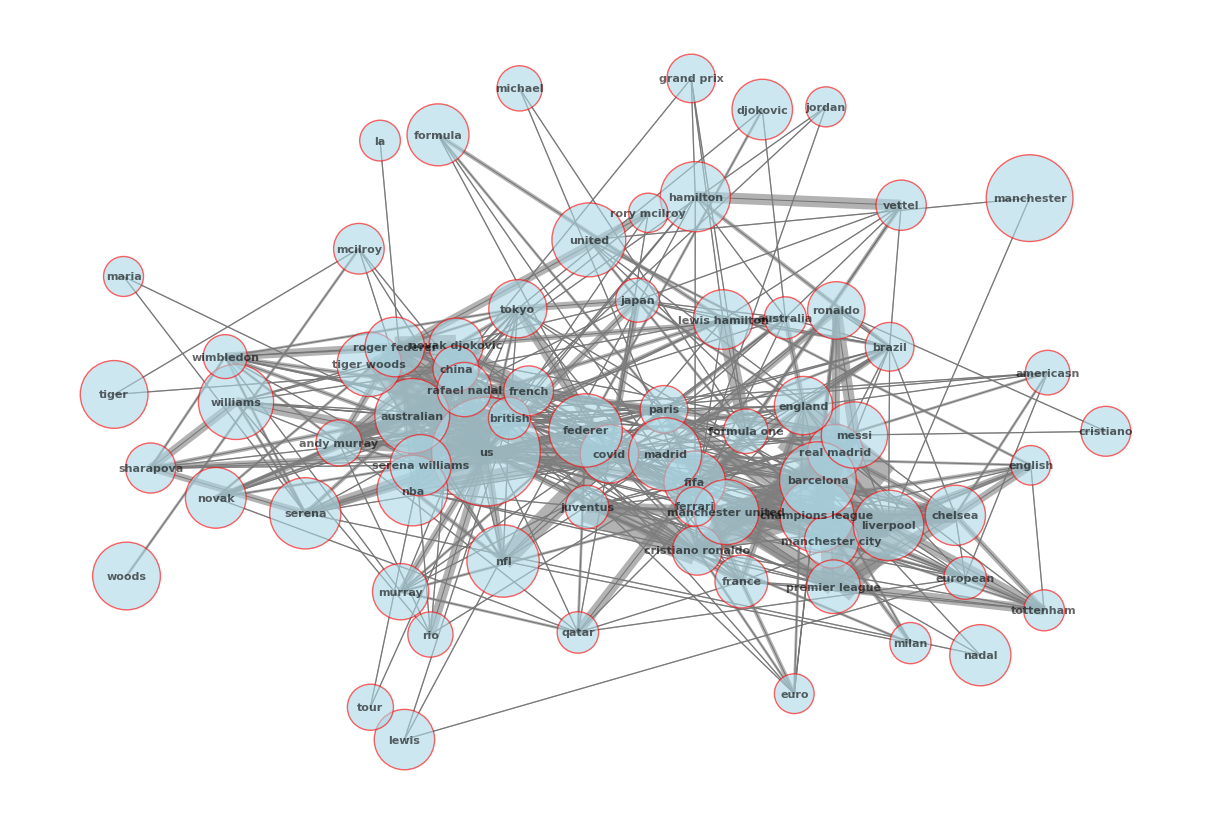

In [56]:
# Draw the graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G3, k = 0.9, iterations = 30)  
G3.remove_edges_from(nx.selfloop_edges(G3))
nx.draw(G3, pos, with_labels=True, font_size=8, font_color='black', 
        node_size=node_sizes3, font_weight='bold', width = 0.75, 
        edgecolors='red', node_color='lightblue', alpha = 0.6)

# Add edge labels with weights
labels = nx.get_edge_attributes(G3, 'weight')
nx.draw_networkx_edges(G3, pos, width = list(labels.values()), 
                    alpha = 0.6, edge_color = 'grey')

plt.show()

k-means clustering 

In [823]:
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(dat_sport['tidy_Second headline'])

from sklearn.cluster import KMeans

# initialize KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
clusters = kmeans.labels_

# compute the centroid of each cluster
df = pd.DataFrame(X.todense()).groupby(clusters).mean()
terms = tfidf.get_feature_names_out()
# obtain 10 words with the highest tf-idf score for each cluster
for i, r in df.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([terms[t] for t in np.argsort(r)[-10:]]))



Cluster 0
title,wins,woods,olympic,new,star,olympics,win,football,says

Cluster 1
record,davis,series,americas,women,win,rugby,ryder,cup,world

Cluster 2
english,city,liverpool,barcelona,manchester,real,madrid,premier,champions,league

Cluster 3
rafael,roger,french,djokovic,serena,williams,australian,nadal,federer,open


In [844]:
n_clusters = 4
top_cluster_words = []
for i in range(n_clusters):
    aa = []
    row = df.iloc[i]
    for t in np.argsort(row)[-50:]:
        aa.append(terms[t]) 
    top_cluster_words.append(aa)   

# np.array(top_cluster_words)

In [846]:
def generate_word_cloud(cluster_words):
    n_clusters = len(cluster_words)
    # create word clouds for each cluster
    for i in range(n_clusters):
        word_cloud = WordCloud(width=500, height=300, background_color='white', max_font_size=100,
                            random_state=0).generate(' '.join(cluster_words[i]))
        # plt.figure(figsize=(5,5))
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.title('Cluster {}'.format(i))
        plt.axis('off')
        plt.show()

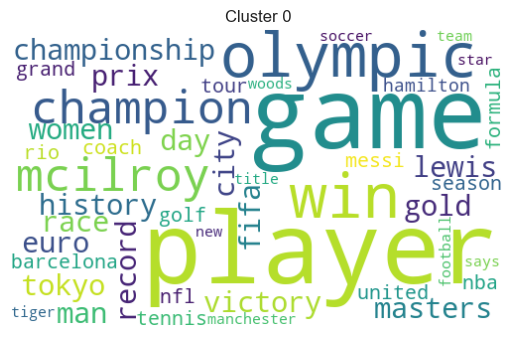

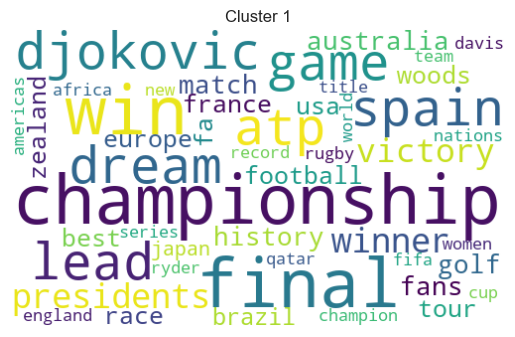

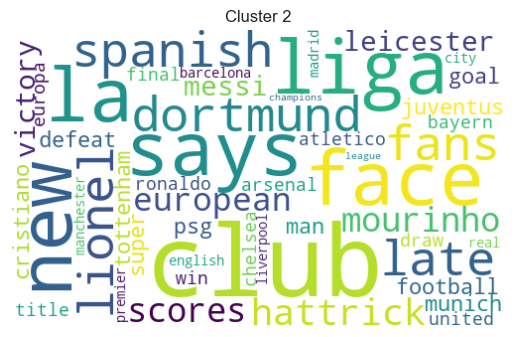

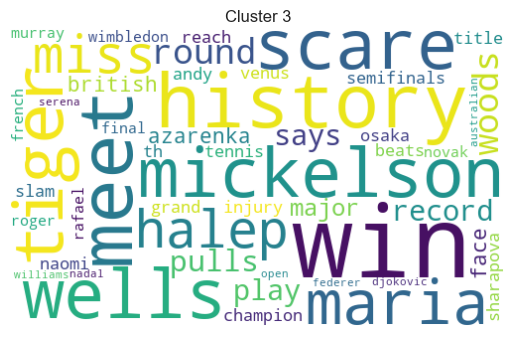

In [847]:
generate_word_cloud(top_cluster_words)